# Setup

In [65]:
%load_ext autoreload
%autoreload 2
%aimport

%matplotlib inline 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [66]:
from sparse_field_lib import load_data

In [67]:
import matplotlib.pyplot as plt
import torch

from bliss.datasets import sdss
from bliss.models import encoder, decoder
from bliss import sleep

In [68]:
sdss_dir = '/home/imendoza/bliss/data/sdss/'

In [69]:
device = 'cuda:4'

# Load data

In [87]:
sdss_data = sdss.SloanDigitalSkySurvey(
    sdss_dir=sdss_dir,
    run=94,
    camcol=1,
    fields=(12,),
    bands=range(5),
    overwrite_cache=True,
    overwrite_fits_cache=True,
)

In [88]:
image = torch.Tensor(sdss_data[0]["image"])

In [90]:
[im.mean() for im in image]

[tensor(64.5574),
 tensor(354.9348),
 tensor(874.3302),
 tensor(1429.7260),
 tensor(863.9210)]

In [77]:
image, fits_file, wcs_list, sdss_data = load_data(sdss_dir=sdss_dir)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '19/09/98' to '1998-09-19''. [astropy.wcs.wcs]


In [78]:
psf = sdss_data.rcfgcs[0][-1]
_psf = psf.psf_at_points(0, 450, 550)

In [79]:
import galsim
psf_image = galsim.Image(_psf, scale=0.396)
interp = galsim.InterpolatedImage(psf_image)
interp.calculateFWHM()

1.425650871818947

In [80]:
wcs = wcs_list[0]

In [81]:
pt, pr = wcs.all_world2pix(fits_file['ra'][:], fits_file['dec'][:], 0)

## Look at complete image

791.3096923828125 956.1792169189453


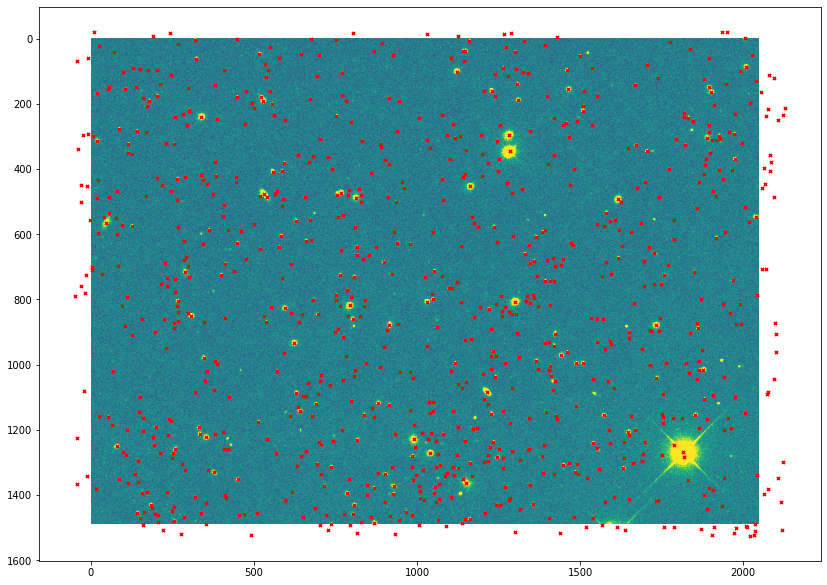

In [82]:
%matplotlib inline
plt.figure(figsize=(14,14))
vmin = np.percentile(image.flatten(), 1)
vmax = np.percentile(image.flatten(), 99)
print(vmin, vmax)

plt.imshow(image[0], vmin=vmin, vmax=vmax)
plt.scatter(pt, pr, marker='x', color='r', s=10)
# plt.colorbar()

## choose one chunk

In [83]:
# prepare chunk
# i, j = np.random.randint(0, 6, size=(2))
# i,j = (1,5)
clen = 200
xlim = (450, 650)
ylim = (350, 550)
print(xlim, ylim)

chunk = image[0, ylim[0]:ylim[1], xlim[0]:xlim[1]]

pt, pr = wcs.all_world2pix(fits_file['ra'][:], fits_file['dec'][:], 0)

# restrict to 200x200 chunk 
keep = (pt > xlim[0]) & (pt < xlim[1]) & (pr < ylim[1]) & (pr > ylim[0])

# obtain star and galaxy bools for each location.
is_star = fits_file['probpsf'][:].astype(bool)
galaxy_bool = (~is_star) & keep
star_bool = is_star & keep

(450, 650) (350, 550)


In [84]:
# move image to device
slen = 200
chunks = chunk.reshape(1, 1, *chunk.shape)[:, :, :slen, :slen].to(device)
print(chunks.shape)

torch.Size([1, 1, 200, 200])


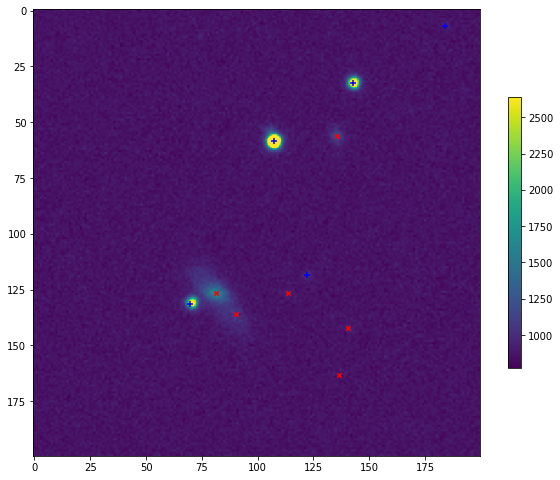

In [85]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))


p_level = 0.1
vmin = np.percentile(chunk.flatten(), p_level)
vmax = np.percentile(chunk.flatten(), 100-p_level)

# account for bia
_pt = pt - xlim[0]
_pr = pr - ylim[0]

# and show it with correct centers.
im = ax.imshow(chunk, vmin=vmin, vmax=vmax)
ax.scatter(_pt[galaxy_bool], _pr[galaxy_bool], marker='x', color='r', s=20)
ax.scatter(_pt[star_bool], _pr[star_bool], marker='+', color='b', s=30)
fig.colorbar(im, ax=ax, shrink=0.5)

In [86]:
chunk[0:50, 0:25].mean()

tensor(863.8591)

## get estimate from chunk

In [ ]:
# read sleep 
checkpoint_file = '/home/imendoza/bliss/data/sleep_galaxy_star_trained1.ckpt'
sleep_net= sleep.SleepPhase.load_from_checkpoint(checkpoint_file).to(device)
image_encoder = sleep_net.image_encoder
galaxy_encoder = sleep_net.galaxy_encoder

# important to turn on .eval() mode!
sleep_net = sleep_net.eval()
image_encoder = image_encoder.eval()

In [ ]:
with torch.no_grad():

    tile_est = sleep_net.tile_images_map_estimate(chunks)
    sleep_net.image_decoder.background_values = (633.0, )
    
    # plot image from tile est.
    recon_image, _ = sleep_net.image_decoder.render_images(
        tile_est["n_sources"],
        tile_est["locs"],
        tile_est["galaxy_bool"],
        tile_est["galaxy_params"],
        tile_est["fluxes"],
        add_noise=False,
    )
    
    _slen = chunks.shape[-1] - image_encoder.border_padding*2
    print(_slen)
    est_params = encoder.get_full_params(tile_est, _slen)

In [ ]:
combined = np.hstack([chunk.flatten(), _recon_image.flatten()])
combined.shape

In [ ]:
# plot both images side by side.
fig, axes = plt.subplots(1, 2, figsize=(12,6))
_recon_image = recon_image.detach().cpu().numpy()[0, 0]

ax1, ax2 = axes


p = 0.1
combined = np.hstack([chunk.flatten(), _recon_image.flatten()])
vmin = np.percentile(combined, p)
vmax = np.percentile(combined, 100-p)

# plot the chunk and reconstruction image side by side.
im1 = ax1.imshow(chunk, vmin=vmin, vmax=vmax)
im2 = ax2.imshow(_recon_image, vmin=vmin, vmax=vmax)

# true image and true locations
ax1.scatter(_pt[galaxy_bool], _pr[galaxy_bool], marker='x', color='r', s=20)
ax1.scatter(_pt[star_bool], _pr[star_bool], marker='+', color='b', s=30)


# overlay the map estimate params on the full image
_locs = est_params['locs']*_slen + image_encoder.border_padding
_locs = _locs.detach().cpu().numpy()[0]
_galaxy_bool = est_params['galaxy_bool'].bool().detach().cpu().numpy()[0, :, 0]
ax2.scatter(_locs[:, 1][_galaxy_bool], _locs[:, 0][_galaxy_bool], marker='x', color='r', s=25)
ax2.scatter(_locs[:, 1][~_galaxy_bool], _locs[:, 0][~_galaxy_bool], marker='+', color='b', s=30)

# colorbar
fig.colorbar(im1, ax=ax1, shrink=0.5)
fig.colorbar(im2, ax=ax2, shrink=0.5)

plt.tight_layout()